# Predicting Credit Risks
## Introduction

The objective of this case study is to fit and compare five different binary classifiers to predict whether a customer has good or bad credit risks in the German credit data sourced from the OpenML (originally adopted from UCI Machine Learning Repository) (Dua and Graff, 2019). The descriptive features include 7 numeric and 13 nominal categorical features. The target feature has two classes defined as "good" and "bad" respectively. The full dataset contains 1000 observations.

This report is organised as follows:
* [Overview](#overview) section describes the dataset used in this study and outlines the methodology.
* [Data Preparation](#data_preparation) section summarises the statistics and contains data cleaning.
* [Data Exploration](#data_exploration) section visually explores the dataset features and inter-relationships.
* [Data Preprocessing](#data_preprocessing) section prepares the dataset features for scikit learn modules and performs feature selection. 
* [Predictive Modelling](#predictive_modelling)section describes the hyperparameter tuning process for each classification algorithm.
* [Performance Comparison](#performance_comparison) section presents the performance comparison results.
* [Limitations and Proposed Solutions](#limitations) section provides an overview of the limitations of our proposed solution.
* [Summary and Conclusion](#conclusion) section provides a summary of this study.
* [Reference](#reference) section recognises all the published work borrowed. 

Compiled from a Jupyter Notebook, this report contains both narratives and the Python code used throughout the project.

## Overview <a class="anchor" id="overview"></a>
### Target Feature
Our target feature is `class` which is a binary feature. Hence, our project is on a binary classification problem.

### Descriptive Features
The variable descriptions below are from the OpenML website [here](https://www.openml.org/d/31):
- Attribute 1:`checking_status`: '<0', '0<=X<200', 'no checking', '>=200'.
- Attribute 2: `duration`: numeric.
- Attribute 3: `credit_history`: 'critical/other existing credit', 'existing paid', 'delayed previously', 'no credits/all paid', 'all paid'.
- Attribute 4:`purpose`: 'radio/tv', 'education', 'furniture/equipment', 'new car', 'used car', 'business', 'domestic appliance', 'repairs', 'other', 'retraining'.
- Attribute 5: `credit_amount`: numeric. 
- Attribute 6: `savings_status`: 'no known savings', '<100' '500<=X<1000', '>=1000', '100<=X<500'.
- Attribute 7: `employment`: '>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1'.
- Attribute 8:`installment_commitment`:numeric.
- Attribute 9: `personal_status`: 'male single', 'female div/dep/mar', 'male div/sep', 'male mar/wid'.
- Attribute 10: `other_parties`: 'none', 'guarantor', 'co applicant'.
- Attribute 11: `residence_since`:numeric.
- Attribute 12: `property_magnitude`: 'real estate', 'life insurance', 'no known property', 'car'.
- Attribute 13: `age`:numeric.
- Attribute 14: `other_payment_plans`: 'none', 'bank', 'stores'.
- Attribute 15: `housing`: 'own', 'for free', 'rent'.
- Attribute 16: `existing_credits`:numeric.
- Attribute 17: `job`: 'skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res'.
- Attribute 18: `num_dependents`: numeric. 
- Attribute 19: `own_telephone`: 'yes', 'none'.
- Attribute 20: c: 'yes', 'no'.

### Methodology
In this study, we will consider the following five classifiers to predict the target feature:

* K-Nearest Neighbours (KNN),
* Decision trees (DT),
* Gaussian Naive Bayes (NB),
* Random Forests (RF),
* Support Vector Machine (SVM).

Our modeling strategy begins with getting the full dataset ready for Scikit Learn modules. This process includes cleaning the dataset, exploration on the dataset features inter-relationships, encoding categorical descriptive features as numerical and then scaling descriptive features. The full dataset is then split into training and test sets with a 70:30 ratio. As a result, our training data for hyperparameter tuning has 700 rows and test data has 300 rows which will be used in for performance comparison. 

Before fitting a classifier on the training data, we perform feature selection with the following methods:

* F-score
* Random Forest Importance
* Mutual Information

This gives us some ideas of which descriptive features are more important/relevant for predicting target. Through evaluation on each method's performance, F-score is selected to use in later hyperparameter tuning phase inside a pipeline. We consider 10, 20, and the full set of features (with 60 features after encoding). Using feature selection together with hyperparameter search inside a single pipeline, we conduct a 3-repeats 5-fold stratified cross-validation to fine-tune hyperparameters of each classifier using area under curve (AUC) as the performance metric. Since the target feature has more individuals with 'good' credit risks (unbalanced target class issue), stratification based on target is crucial to ensure each validation set has the same proportion of classes as original data.

Once the best hyperparameter values through grid search for each classifier are successfully identified, they will be fit on the test data using a 10-fold cross validation in paired t-tests to see if there is any statistically significant performance difference. In our study, it is worse to class a customer as good when they are bad compared to the other way around, so we will also compare the classifiers with respect to their recall scores and confusion matrices on the test data.

In [1]:
#!pip install --upgrade altair

#!pip install vega vega_datasets

In [2]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_columns', None)

# Data Preparation  <a class="anchor" id="data_preparation"></a>
### Loading Dataset

We load the dataset from local project. The dataset has 1000 observations and 20 descriptive features and "class" target feature. Looking at the dataset, some values come with single quotation mark. This will to be removed. 

In [5]:
df = pd.read_csv('dataset_31_credit-g.csv', sep= ',',na_values=["?"])
print(df.shape)
df.head()

(1000, 21)


checking_status  duration                    credit_history  \
0            '<0'         6  'critical/other existing credit'   
1      '0<=X<200'        48                   'existing paid'   
2   'no checking'        12  'critical/other existing credit'   
3            '<0'        42                   'existing paid'   
4            '<0'        24              'delayed previously'   

               purpose  credit_amount      savings_status employment  \
0             radio/tv           1169  'no known savings'      '>=7'   
1             radio/tv           5951              '<100'   '1<=X<4'   
2            education           2096              '<100'   '4<=X<7'   
3  furniture/equipment           7882              '<100'   '4<=X<7'   
4            'new car'           4870              '<100'   '1<=X<4'   

   installment_commitment       personal_status other_parties  \
0                       4         'male single'          none   
1                       2  'female div/dep/mar'          none   
2                       2         'male single'          none   
3                       2         'male single'     guarantor   
4                       3         'male single'          none   

   residence_since   property_magnitude  age other_payment_plans     housing  \
0                4        'real estate'   67                none         own   
1                2        'real estate'   22                none         own   
2                3        'real estate'   49                none         own   
3                4     'life insurance'   45                none  'for free'   
4                4  'no known property'   53                none  'for free'   

   existing_credits                   job  num_dependents own_telephone  \
0                 2               skilled               1           yes   
1                 1               skilled               1          none   
2                 1  'unskilled resident'               2          none   
3                 1               skilled               2          none   
4                 2               skilled               2          none   

  foreign_worker class  
0            yes  good  
1            yes   bad  
2            yes  good  
3            yes  good  
4            yes   bad

Checking the dataset again, after removing unusual symbol.

In [6]:
df = df.replace({'\'': ''}, regex=True) #remove single quote from df
df.head()

checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  residence_since  \
0                       4         male single          none                4   
1                       2  female div/dep/mar          none                2   
2                       2         male single          none                3   
3                       2         male single     guarantor                4   
4                       3         male single          none                4   

  property_magnitude  age other_payment_plans   housing  existing_credits  \
0        real estate   67                none       own                 2   
1        real estate   22                none       own                 1   
2        real estate   49                none       own                 1   
3     life insurance   45                none  for free                 1   
4  no known property   53                none  for free                 2   

                  job  num_dependents own_telephone foreign_worker class  
0             skilled               1           yes            yes  good  
1             skilled               1          none            yes   bad  
2  unskilled resident               2          none            yes  good  
3             skilled               2          none            yes  good  
4             skilled               2          none            yes   bad

### Data Cleaning and Transformation

First we check column type to ensure all features are read in with proper classification. That is, numeric features are "int64" or "float"; while categorical features are "object".

In [7]:
df.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

### Preliminary Check
#### Dropping ID-Like Columns, Remove Irrelevant and Redundant Features
The dataset we are using does not include any ID-like feature. All features are relevant and there is no redundant feature in the dataset. So all descriptive features are retained for modeling.

### Summary Statistics

**Table 1: Summary of numeric features**

Here notice that `credit_amount` has relatively large values compared to `installment_commitment`, `residence_since`, `num_dependents`, so scaling is crucial so that KNN algorithm will not heavily affected by `credit_amount`. Also,`num_dependents` is discrete. Other continuous features like `existing_credits`, `residence_since`, `installment_commitment` are recorded in a way that appears to be discrete (integer value) but are still continuous in nature.

**Table 2: Summary of categorical features**

In [8]:
df.describe(include = np.object)  # categorical features

checking_status credit_history   purpose savings_status employment  \
count             1000           1000      1000           1000       1000   
unique               4              5        10              5          5   
top        no checking  existing paid  radio/tv           <100     1<=X<4   
freq               394            530       280            603        339   

       personal_status other_parties property_magnitude other_payment_plans  \
count             1000          1000               1000                1000   
unique               4             3                  4                   3   
top        male single          none                car                none   
freq               548           907                332                 814   

       housing      job own_telephone foreign_worker class  
count     1000     1000          1000           1000  1000  
unique       3        4             2              2     2  
top        own  skilled          none            yes  good  
freq       713      630           596            963   700

### Checking Missing Values
Now we can check if there is any missing values.

In [9]:
df.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

Sometimes missing values are recorded in a different way so we also check the levels of all categorical features to ensure no missing/unusual values.

In [10]:
# check unusual values 
categoricalColumn = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude',
                     'other_payment_plans','housing','job','own_telephone','foreign_worker']

for col in categoricalColumn:
    print('Unique values for ' + col)
    print(df[col].unique())
    print('')

Unique values for checking_status
['<0' '0<=X<200' 'no checking' '>=200']

Unique values for credit_history
['critical/other existing credit' 'existing paid' 'delayed previously'
 'no credits/all paid' 'all paid']

Unique values for purpose
['radio/tv' 'education' 'furniture/equipment' 'new car' 'used car'
 'business' 'domestic appliance' 'repairs' 'other' 'retraining']

Unique values for savings_status
['no known savings' '<100' '500<=X<1000' '>=1000' '100<=X<500']

Unique values for employment
['>=7' '1<=X<4' '4<=X<7' 'unemployed' '<1']

Unique values for personal_status
['male single' 'female div/dep/mar' 'male div/sep' 'male mar/wid']

Unique values for other_parties
['none' 'guarantor' 'co applicant']

Unique values for property_magnitude
['real estate' 'life insurance' 'no known property' 'car']

Unique values for other_payment_plans
['none' 'bank' 'stores']

Unique values for housing
['own' 'for free' 'rent']

Unique values for job
['skilled' 'unskilled resident' 'high qualif/se

### Detecting outliers

For our numerical features, we need to check if there is any outliers. `Residence_since`, `existing_credits`, `installment_commitment`, `num_dependents` are discrete like and vary between 1-4, so no need to check outliers on those features. 
<p>The following features are investigated here:`duration`, `credit_amount`,`age`.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

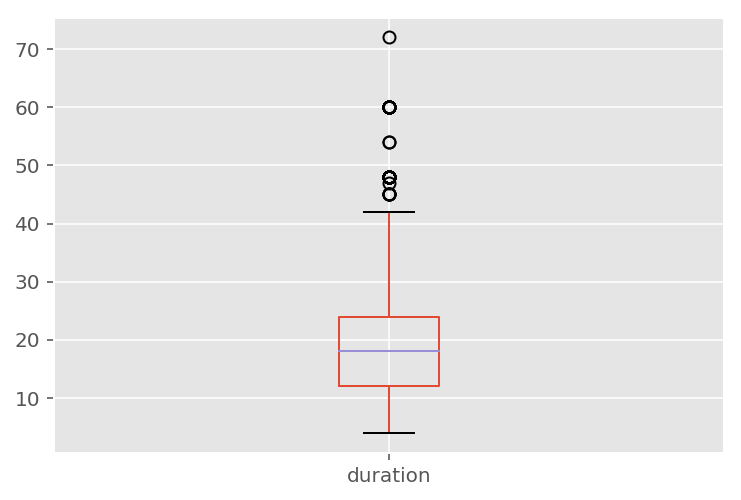

In [12]:
df.boxplot(column=['duration'])

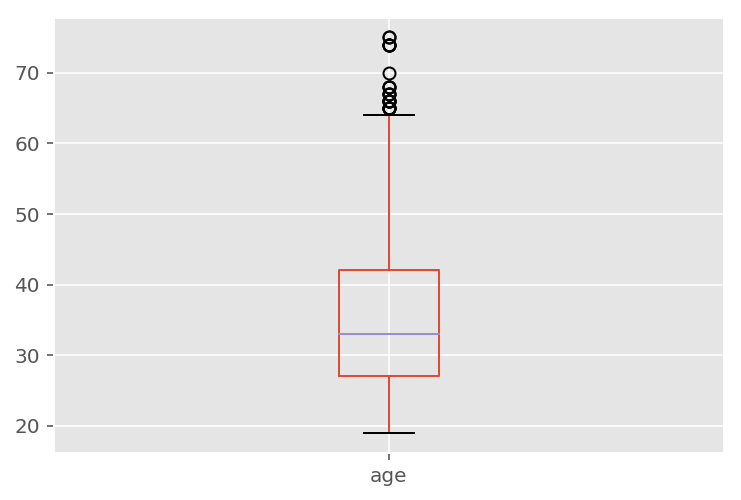

In [13]:
df.boxplot(column=['age'])

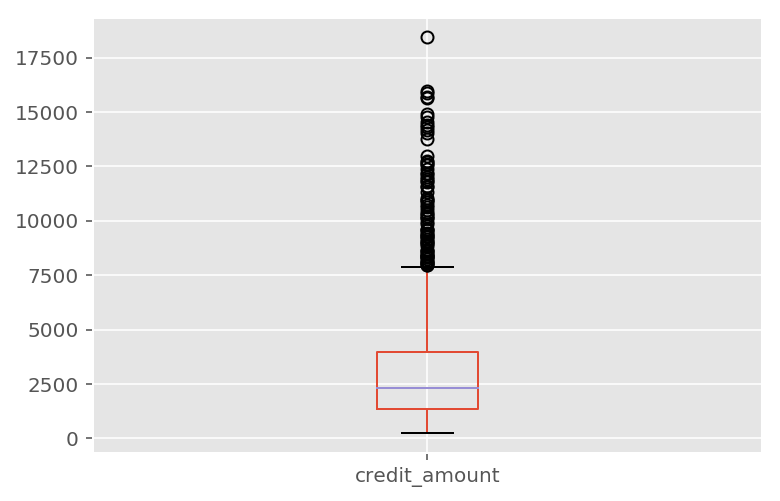

In [14]:
df.boxplot(column=['credit_amount'])

Observation:
<p>The boxplot of the 3 attributes exhibit some potential outliers which are outside the upper IQR boundary. Looking into this in further details, for `credit_amount`, although there are many large values over the boundary, it's reasonable to believe that different people can have different credit balance and one's may be larger than others. So in this case without further investigation, the records with large credit amount will be retained. Similarly, for `age` and `duration`, observations are aged between 19 and 75 and credit durations are between 4 to 72 months, there's nothing odd. Just be mindful that the distribution of these features is right-skewed.

### Splitting combined features
The feature `personal_status` came to our attention as it contains a combination of two different "features": gender and marital status. For our models to better learn about the data, we decide to split this feature into `gender` and `marital_status`.

In [15]:
new = df["personal_status"].str.split(' ', n = 1, expand = True)
df["gender"] = new[0]
df["marital_status"] = new[1]
df.drop(columns =["personal_status"], inplace = True)

In [16]:
df = df[[col for col in df.columns if col not in ['class']] + ['class']]

In [17]:
df.head(5)

checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment other_parties  residence_since property_magnitude  \
0                       4          none                4        real estate   
1                       2          none                2        real estate   
2                       2          none                3        real estate   
3                       2     guarantor                4     life insurance   
4                       3          none                4  no known property   

   age other_payment_plans   housing  existing_credits                 job  \
0   67                none       own                 2             skilled   
1   22                none       own                 1             skilled   
2   49                none       own                 1  unskilled resident   
3   45                none  for free                 1             skilled   
4   53                none  for free                 2             skilled   

   num_dependents own_telephone foreign_worker  gender marital_status class  
0               1           yes            yes    male         single  good  
1               1          none            yes  female    div/dep/mar   bad  
2               2          none            yes    male         single  good  
3               2          none            yes    male         single  good  
4               2          none            yes    male         single   bad

# Data Exploration <a class="anchor" id="data_exploration"></a>

Our dataset can now be considered "clean" and ready for visualisation and statistical modeling.

### Univariate Visualisation

Let's get a histogram of `duration`.

Figure 1 shows `duration` is right-skewed with a mean of 20.9 months, median of 18 months and large observations at the right tail. Around 50% of the durations are between 10 to 25 months. Nearly 20% of the observations are between 25 to 50 months. There are a few large observations such as 54, 60 and 72 months, which may suggest high credit risks.

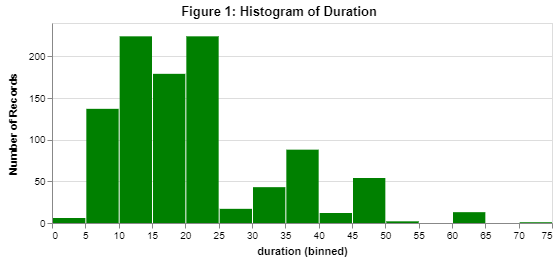

In [18]:
alt.Chart(df, title = 'Figure 1: Histogram of Duration', width=300
         ).mark_bar(color='green'
                   ).encode(alt.X('duration', bin=alt.Bin(maxbins=20)), y='count()'
                           ).interactive(
                                            ).properties(width=500, height = 200)

Let's display a boxplot for `credit_amount`. 

Figure 2 shows this variable is highly right-skewed with a mean of 3,271.26, median of 2,319.50 and extreme observations at the right tail. 50% of the observations are between 1,365.50 (Q1) and 3,972.25 (Q3). Values larger than 7,500 (Q3 + 1.5 × IQR) show extreme credit amount. The maximum credit amount in the data is 18,424.00. We keep these extreme values since they may suggest high credit risks. 

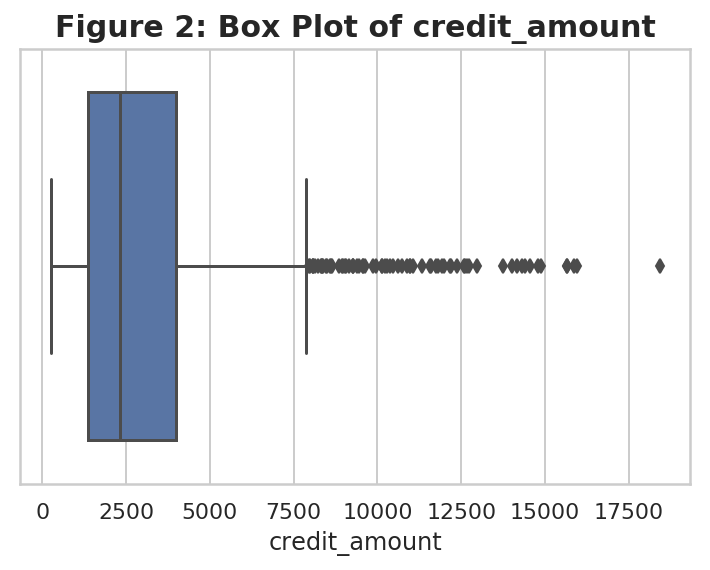

In [19]:
sns.set(style="whitegrid")
sns.boxplot(df['credit_amount']).set_title('Figure 2: Box Plot of credit_amount', fontsize = 15, fontweight="bold")
plt.show()

Let's plot the bar chart of target variable `class`.

Figure 3 shows the target variable is imbalanced. There are 300 bad credits and 700 good credits in the data. We need to ensure the target is stratified when using holding-out sampling and cross validation method so that the proportions of bad and good credits will be preserved.

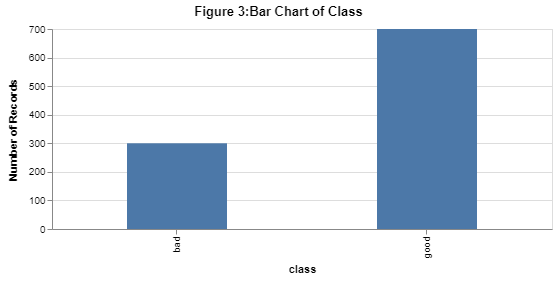

In [20]:
alt.Chart(df, title = 'Figure 3:Bar Chart of Class', width=300).mark_bar(size=100).encode(
    x='class', 
    y= 'count()'
).interactive(
).properties(width=500, height = 200)

Let's display the histogram of `age`.

Figure 4 shows the distribution of age is right-skewed with a mean of 35.55 years, median of 33 years, and large observations such as 75 years at the right tail. 50% of people are between 27 to 42 years, around 20% of people are between 42 to 60 years. There are a few observations of age from 60 to 75 years. The relationship between age and other variables will need to be checked to explore if they suggest high credit risks.

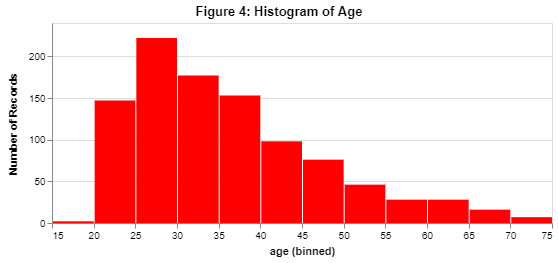

In [21]:
alt.Chart(df, title = 'Figure 4: Histogram of Age'
         ).mark_bar(color='red'
                   ).encode(alt.X('age', bin=alt.Bin(maxbins=20)), y='count()'
                           ).interactive(
                                            ).properties(width=500, height = 200)

### Multivariate Visualisation

Now let's display the scatter plot between `age` and `credit_amount`. 

Figure 5 shows no obvious linear correlation between `age` and `credit_amount`.   

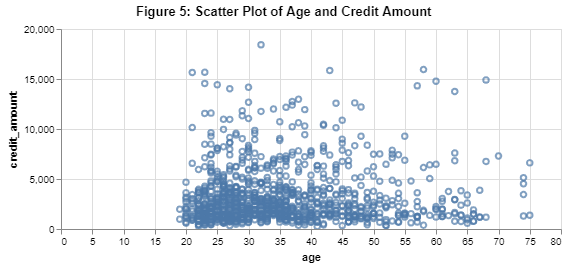

In [22]:
alt.Chart(df, title = 'Figure 5: Scatter Plot of Age and Credit Amount'
         ).mark_point(
            ).encode(x='age', y='credit_amount'
                    ).interactive(
                            ).properties(width=500, height = 200)

Let's display the bar chart with colour facet for `existing_credits` and `gender`.

Figure 6 shows male tend to have more existing credits than female for all number of existing credits (1 to 4). For example, around 200 female have 1 credit while around 400 male have 1 credit. In addition, around 90% of people have 1 and 2 existing credits while only 10% of the remaining have 3 and 4 credits. 

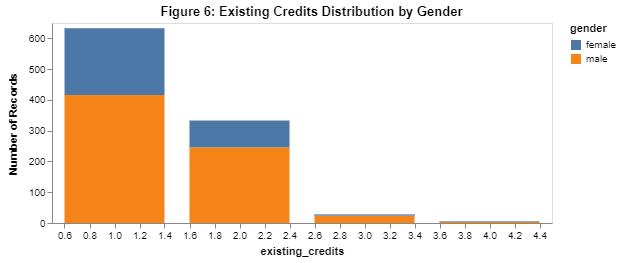

In [23]:
alt.Chart(df, title = 'Figure 6: Existing Credits Distribution by Gender', width=500).mark_bar(size=100).encode(
    x='existing_credits', 
    y='count()', 
    color='gender'
        ).interactive(
            ).properties(width=500, height = 200
                        ).configure_axis(grid=False)

Let's display the box plot by `class` and `credit_amount`.

Figure 7 shows people classified with bad credit have larger mean, median and credit amount with more extreme values (e.g. values larger than 10,000). So high `credit_amount` may suggest high credit risks. 

Text(0.5, 1.0, 'Figure 7: Box Plot of Class and Credit Amount')

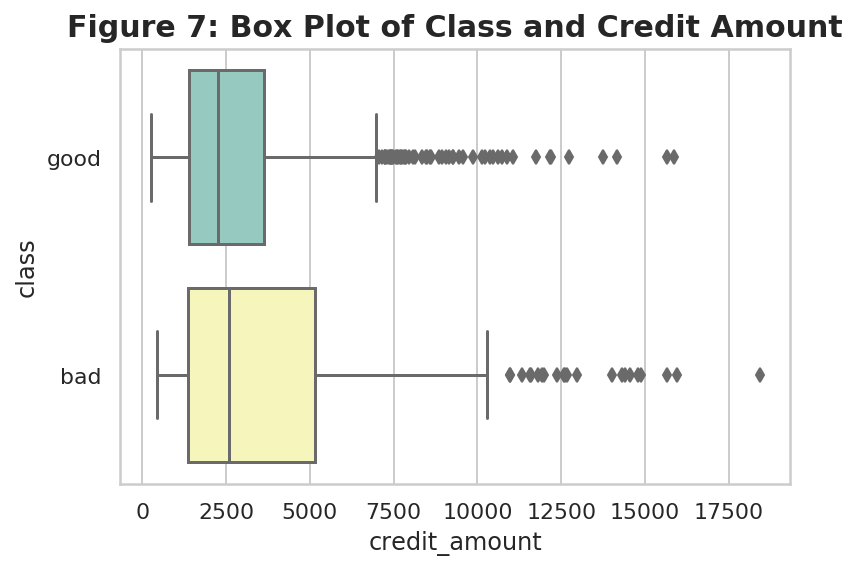

In [24]:
sns.set(style="whitegrid")
sns.boxplot(x="credit_amount", y="class", data=df, palette="Set3").set_title('Figure 7: Box Plot of Class and Credit Amount', fontsize = 15, fontweight="bold")

Let's plot the bar chart with colour facet for `employment` and `savings_status`. 

Figure 8 shows people employed between 1 to 4 years have more proportions for savings between 500 to 1000 than other groups in the data. In addition, the chart shows there are more people employed between 1 to 4 years in the data.

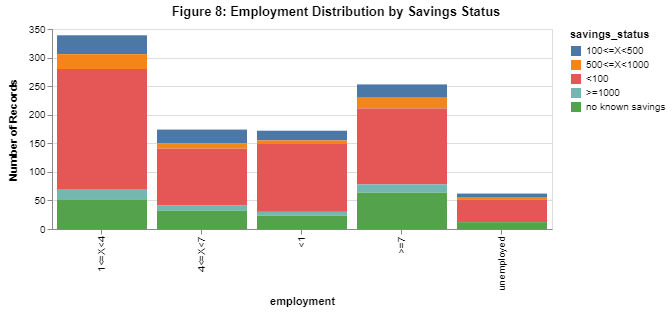

In [25]:
alt.Chart(df, title = 'Figure 8: Employment Distribution by Savings Status', width=300).mark_bar().encode(
    x='employment', 
    y='count()', 
    color='savings_status'
        ).interactive(
            ).properties(width=500, height = 200)

### Three-variable Plots

Let's shows the scatter plot between `age` and `credit_amount` with colour facet of target variable.

Figure 9 shows people aging between 20 and 55 have more bad credits than people larger than 55 years old. In addition, people with higher `credit_amount` tend to have more bad credits as illustrated in the previous section. There is no obvious relationship between `age` and `credit_amount` as stated in the previous section.

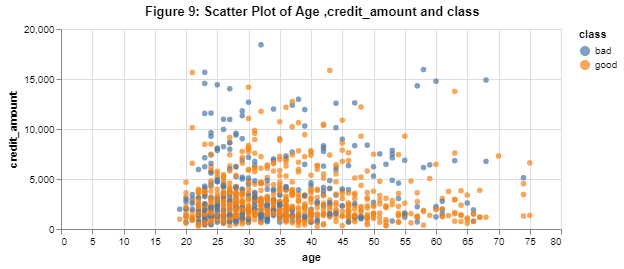

In [26]:
alt.Chart(df, title = 'Figure 9: Scatter Plot of Age ,credit_amount and class'
         ).mark_point(
                ).encode(x='age', y='credit_amount', fill = 'class'
                        ).interactive(
                            ).properties(width=500, height = 200)

Let's now display the side by side box plots of `credit history` and `credit_amount` with colour of target feature `class`.

Figure 10 shows people who have no credits or paid all credits till duly tend to higher mean, median and extreme `credit_amount` than the other four types in `credit history`. 

In addition, people who have critical/ other existing credit and existing paid tend to have higher mean and median values for bad credits. For people who delayed paid previously and paid all credits in this bank, the mean and median for bad credits tend to be lower than those for good credits. For people with no credits/all paid tend to have similar mean and median for both good and bad credits, but those people with bad credits tend to have more extreme credit amounts.

Text(0.5, 1.0, 'Figure 10: Boxplot of Credit Amount, Credit History and Class')

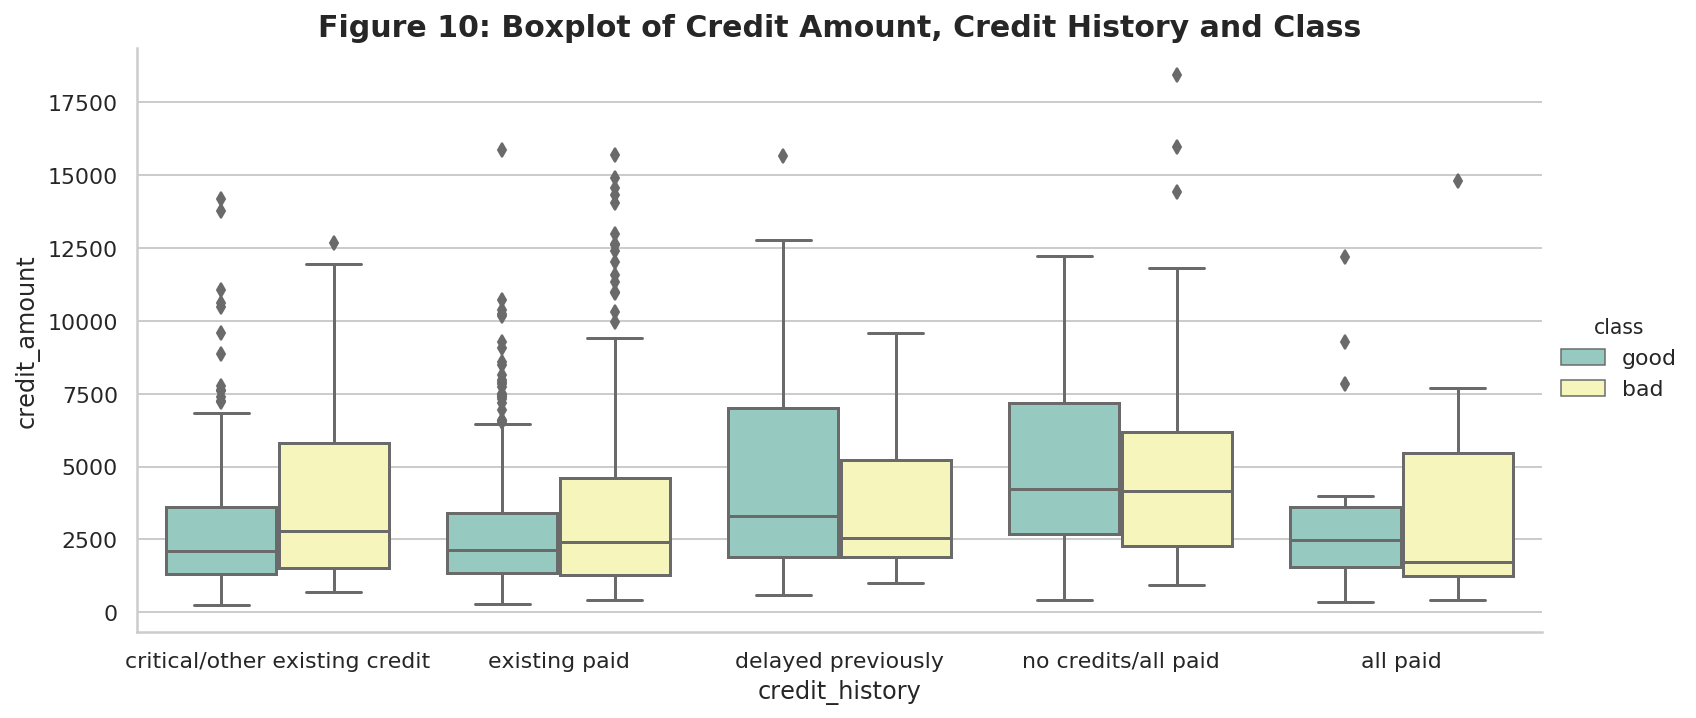

In [27]:
sns.catplot(x="credit_history", y="credit_amount", hue="class", palette = "Set3", data=df, kind="box",height = 5, aspect = 2.2)

plt.title('Figure 10: Boxplot of Credit Amount, Credit History and Class', fontsize = 15,fontweight="bold")

Let's display the scatter plot between `age` and `credit_amount` with colour facet of `gender`.

Figure 11 shows no obvious relationship between `age` and `credit_amount`, `age` and `gender`, and `gender` and `credit_amount`. 

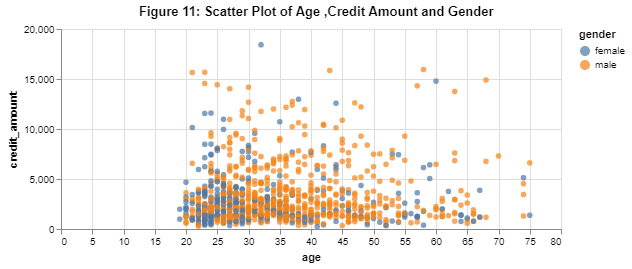

In [28]:
alt.Chart(df, title = 'Figure 11: Scatter Plot of Age ,Credit Amount and Gender'
         ).mark_point(
            ).encode(x='age', y='credit_amount', fill = 'gender'
                    ).interactive(
                        ).properties(width=500, height = 200)

Let's display the side by side box plots of `saving_status` and `credit_amount` with colour of `gender`. 

Figure 12 shows for male who have no known savings, savings<100, >=1000, 100<=x<500, they have higher mean and median than female in those groups. For people with savings 500 <=x < 1000, female tend to have mean and median. 

Text(0.5, 1.0, 'Figure 12: Boxplot of Credit Amount, Savings Status and Gender')

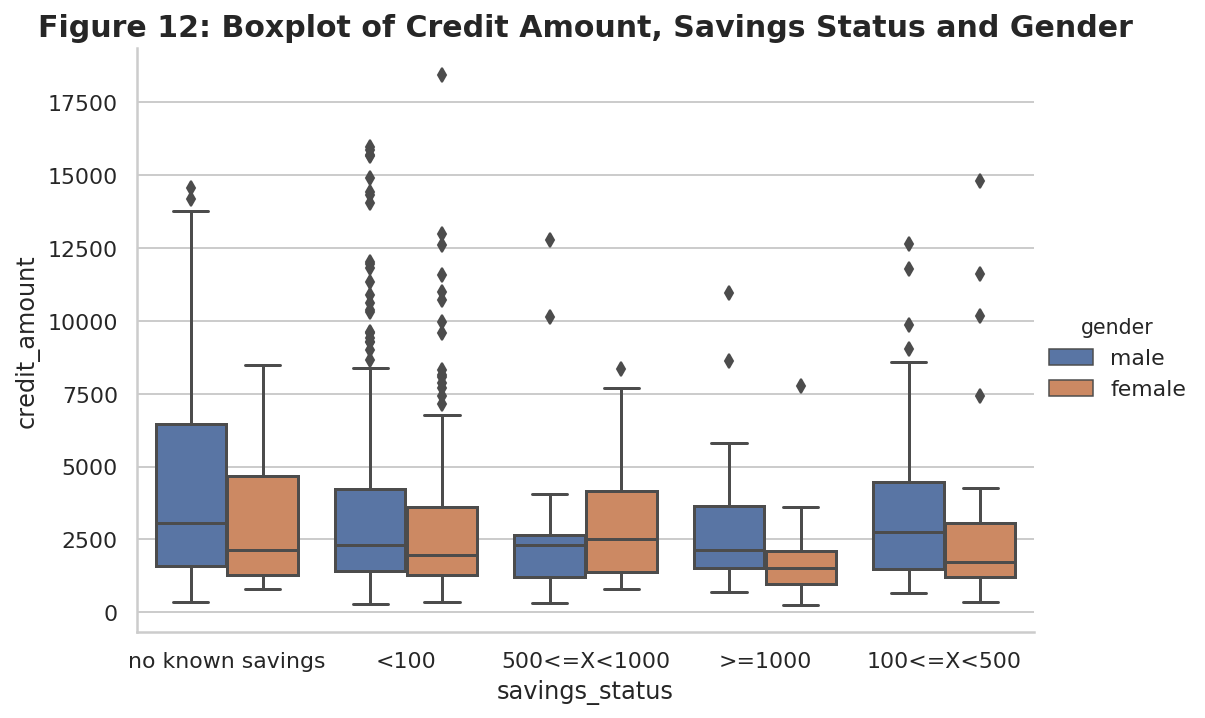

In [29]:
sns.catplot(x="savings_status", y="credit_amount", hue="gender", data=df, kind="box", height = 5, aspect = 1.5)
plt.title('Figure 12: Boxplot of Credit Amount, Savings Status and Gender', fontsize = 15, fontweight="bold")

# Data Preprocessing <a class="anchor" id="data_preprocessing"></a>

### Encoding Categorical Data
#### Encoding The Target Feature
We remove `class` from the full dataset and relabel it "target". The subset with the rest of the features is "Data". Here check the size of each class.

In [30]:
Data = df.drop(columns='class')
target = df['class']
target.value_counts()

good    700
bad     300
Name: class, dtype: int64

Because we are interested in identifying "bad" credit risks so we encode the positive class "bad" as "1". Note that the proportion of two classes is not quite balanced (7:3).

In [31]:
target = target.replace({'good': 0, 'bad': 1})
target.value_counts()

0    700
1    300
Name: class, dtype: int64

#### Encoding Categorical Descriptive Features
All the categorical descriptive features in this dataset are nominal so one-hot-encoding is required. Since we plan on conducting feature selection in the next section, it is not desirable to lose any levels, so we define *q* dummy variables for a categorical descriptive feature with *q* levels. And binary features will be defined as a single dummy variable without losing any information. 
<p> A list of all categorical features in Data is obtained as below:

In [32]:
categorical_cols = Data.columns[Data.dtypes==object].tolist()
categorical_cols

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker',
 'gender',
 'marital_status']

Note `drop_first`option is set to be `True` for binary features to code the variable into a single column of 0 or 1. For features with more than 2 levels, the level of all categorical features are expanded to columns with `get_dummies` function. 

In [33]:
for col in categorical_cols:
    n = len(Data[col].unique())
    if (n == 2):
        Data[col] = pd.get_dummies(Data[col], drop_first=True)
   
# use one-hot-encoding for categorical features with >2 levels
Data = pd.get_dummies(Data)

Data now has the following columns:

In [34]:
Data.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'own_telephone', 'foreign_worker', 'gender', 'checking_status_0<=X<200',
       'checking_status_<0', 'checking_status_>=200',
       'checking_status_no checking', 'credit_history_all paid',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'purpose_business',
       'purpose_domestic appliance', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_new car', 'purpose_other',
       'purpose_radio/tv', 'purpose_repairs', 'purpose_retraining',
       'purpose_used car', 'savings_status_100<=X<500',
       'savings_status_500<=X<1000', 'savings_status_<100',
       'savings_status_>=1000', 'savings_status_no known savings',
       'employment_1<=X<4', 'employment_4<=X<7', 'employment_<1',
       'employment_>=7

In [35]:
Data.shape

(1000, 60)

### Scaling of Features
After encoding all the categorical features, we perform a min-max scaling on the descriptive features. Min-max scaling is selected because from the previous section, we note the distribution of some numeric features are right-skewed so we try to avoid using mean and standard error in scaling.

In [36]:
from sklearn import preprocessing

Data_df = Data.copy()

Data_scaler = preprocessing.MinMaxScaler()
Data_scaler.fit(Data)
Data = Data_scaler.fit_transform(Data)

Below is the descriptive features after scaling. Not the output of scaler is a `Numpy`array which lost all the column names. Column names are recovered with the code below.

In [37]:
Data_after = pd.DataFrame(Data, columns=Data_df.columns)

In [38]:
Data_after.sample(5, random_state=999)

duration  credit_amount  installment_commitment  residence_since  \
842  0.205882       0.093155                1.000000              1.0   
68   0.470588       0.086332                1.000000              1.0   
308  0.058824       0.054308                0.666667              1.0   
881  0.294118       0.496699                0.333333              1.0   
350  0.073529       0.054253                0.000000              1.0   

          age  existing_credits  num_dependents  own_telephone  \
842  0.071429               0.0             0.0            0.0   
68   0.321429               0.0             0.0            1.0   
308  0.089286               0.0             0.0            0.0   
881  0.517857               0.0             0.0            1.0   
350  0.071429               0.0             0.0            1.0   

     foreign_worker  gender  checking_status_0<=X<200  checking_status_<0  \
842             1.0     0.0                       0.0                 0.0   
68              1.0     1.0                       0.0                 0.0   
308             1.0     0.0                       1.0                 0.0   
881             1.0     1.0                       0.0                 0.0   
350             1.0     0.0                       0.0                 0.0   

     checking_status_>=200  checking_status_no checking  \
842                    0.0                          1.0   
68                     0.0                          1.0   
308                    0.0                          0.0   
881                    0.0                          1.0   
350                    0.0                          1.0   

     credit_history_all paid  credit_history_critical/other existing credit  \
842                      0.0                                            0.0   
68                       0.0                                            0.0   
308                      0.0                                            0.0   
881                      0.0                                            0.0   
350                      0.0                                            0.0   

     credit_history_delayed previously  credit_history_existing paid  \
842                                0.0                           1.0   
68                                 0.0                           1.0   
308                                0.0                           1.0   
881                                0.0                           1.0   
350                                0.0                           1.0   

     credit_history_no credits/all paid  purpose_business  \
842                                 0.0               0.0   
68                                  0.0               0.0   
308                                 0.0               0.0   
881                                 0.0               0.0   
350                                 0.0               0.0   

     purpose_domestic appliance  purpose_education  \
842                         0.0                0.0   
68                          0.0                1.0   
308                         0.0                0.0   
881                         0.0                0.0   
350                         1.0                0.0   

     purpose_furniture/equipment  purpose_new car  purpose_other  \
842                          0.0              0.0            0.0   
68                           0.0              0.0            0.0   
308                          1.0              0.0            0.0   
881                          0.0              0.0            0.0   
350                          0.0              0.0            0.0   

     purpose_radio/tv  purpose_repairs  purpose_retraining  purpose_used car  \
842               0.0              1.0                 0.0               0.0   
68                0.0              0.0                 0.0               0.0   
308               0.0              0.0                 0.0               0.0   
881               0.0 

In [39]:
Data_after.describe(include = np.number).round(2)  # numerical features

duration  credit_amount  installment_commitment  residence_since  \
count   1000.00        1000.00                 1000.00          1000.00   
mean       0.25           0.17                    0.66             0.62   
std        0.18           0.16                    0.37             0.37   
min        0.00           0.00                    0.00             0.00   
25%        0.12           0.06                    0.33             0.33   
50%        0.21           0.11                    0.67             0.67   
75%        0.29           0.20                    1.00             1.00   
max        1.00           1.00                    1.00             1.00   

           age  existing_credits  num_dependents  own_telephone  \
count  1000.00           1000.00         1000.00        1000.00   
mean      0.30              0.14            0.16           0.40   
std       0.20              0.19            0.36           0.49   
min       0.00              0.00            0.00           0.00   
25%       0.14              0.00            0.00           0.00   
50%       0.25              0.00            0.00           0.00   
75%       0.41              0.33            0.00           1.00   
max       1.00              1.00            1.00           1.00   

       foreign_worker   gender  checking_status_0<=X<200  checking_status_<0  \
count         1000.00  1000.00                   1000.00             1000.00   
mean             0.96     0.69                      0.27                0.27   
std              0.19     0.46                      0.44                0.45   
min              0.00     0.00                      0.00                0.00   
25%              1.00     0.00                      0.00                0.00   
50%              1.00     1.00                      0.00                0.00   
75%              1.00     1.00                      1.00                1.00   
max              1.00     1.00                      1.00                1.00   

       checking_status_>=200  checking_status_no checking  \
count                1000.00                      1000.00   
mean                    0.06                         0.39   
std                     0.24                         0.49   
min                     0.00                         0.00   
25%                     0.00                         0.00   
50%                     0.00                         0.00   
75%                     0.00                         1.00   
max                     1.00                         1.00   

       credit_history_all paid  credit_history_critical/other existing credit  \
count                  1000.00                                        1000.00   
mean                      0.05                                           0.29   
std                       0.22                                           0.46   
min                       0.00                                           0.00   
25%                       0.00                                           0.00   
50%                       0.00                                           0.00   
75%                       0.00                                           1.00   
max                       1.00                                           1.00   

       credit_history_delayed previously  credit_history_existing paid  \
count                            1000.00                       1000.00   
mean                                0.09                          0.53   
std                                 0.28                          0.50   
min                                 0.00                          0.00   
25%                                 0.00                          0.00   
50%                                 0.00                          1.00   
75%                                 0.00                          1.00   
max                                 1.00                          1.00   

       credit_history_no credits/all paid  purpose_business

Here we take another look of the boxplot of scaled `credit_amount`. Note that the distribution of dots above IQR has not changed.

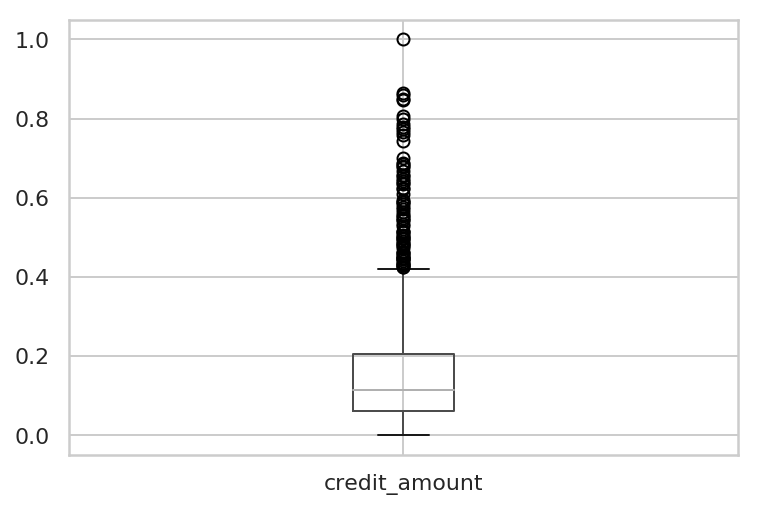

In [40]:
Data_after.boxplot(column=['credit_amount'])

## Feature Selection & Ranking

We will perform feature selection and ranking using the following methods:
* F-score (a statistical filter method)
* Mutual information (an entropy-based filter method)
* Random forest importance (an ensemble-based filter method)

### Full set of features

As wrapper, we use the 1-nearest neighbor classifier. Here we assess the performance using all the descriptive features in the dataset to start with. For assessment, we use a stratified 5-fold cross-validation with 3 repetitions. The random state is set to 999 for replication and verification. 

For scoring, we use the roc_auc score.

In [41]:
clf = KNeighborsClassifier(n_neighbors=1)
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                     n_repeats=3,
                                     random_state=999)
scoring_metric = 'roc_auc'

The cross-validation is performed using the`cross_val_score` function.

In [42]:
cv_results_full = cross_val_score(estimator=clf,
                                 X=Data,
                                 y=target, 
                                 cv=cv_method, 
                                 scoring=scoring_metric)

The array `cv_results_full` contains 15 values corresponding to each one of the 3-repetition/ 5-fold combinations.

In [43]:
cv_results_full

array([0.60833333, 0.6702381 , 0.60357143, 0.62857143, 0.63452381,
       0.60357143, 0.675     , 0.64642857, 0.59761905, 0.6452381 ,
       0.59642857, 0.65357143, 0.66547619, 0.61428571, 0.60119048])

We compute the average cross-validation performance as the mean of the `cv_results_full` array.

In [44]:
cv_results_full.mean().round(3)

0.63

### Feature Selection Using Random Forest Importance

Now we reduce the number of features to 10 and this will be selected by Random Forest Importance (RFI) based on their importance in the full dataset. We will also follow the same procedure as using the full set of features to compute the average cross-validation performance.

In [45]:
from sklearn.ensemble import RandomForestClassifier

num_features = 10 #using 10 features
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features] #finding the features and rank them in a reverse order

best_features_rfi = Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['credit_amount', 'duration', 'age', 'checking_status_no checking',
       'checking_status_<0', 'installment_commitment', 'residence_since',
       'credit_history_critical/other existing credit',
       'savings_status_<100', 'checking_status_0<=X<200'], dtype=object)

In [46]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.09804663, 0.07664401, 0.0764669 , 0.04712189, 0.04244257,
       0.03664   , 0.03489568, 0.02167678, 0.02110125, 0.02017494])

To have a more straight forward understanding, we visualise the importance score in a bar chart as below. The most important feature is `credit_amount` at 0.1, followed by `duration` and `age`at around 0.079, then we have `checking_status_no checking` at 0.05 and the rest of the features selected are less than 0.05.

In [47]:
%config InlineBackend.figure_format = 'retina'

import altair as alt
alt.renderers.enable('notebook') # required in Jupyter notebooks

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.85, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

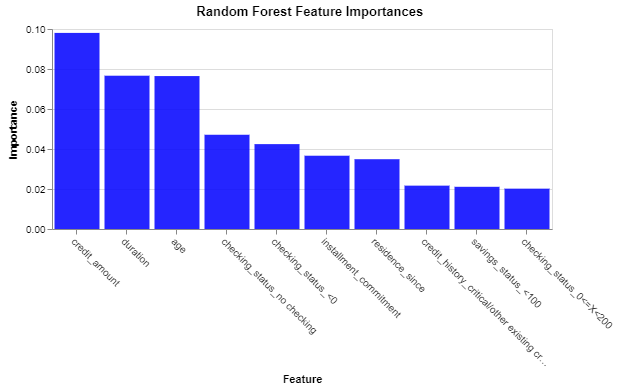

In [48]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'blue')

Let's now assess performance of this feature selection method using cross validation with the 1-nearest neighbour classifier.

In [49]:
cv_results_rfi = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_rfi],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_rfi.mean().round(3)

0.578

### Feature Selection Using F-Score

We will conduct a similar process as what we do in feature selection using RFI to select the 10 most important features. This time, we use the F-Score intead.

In [50]:
from sklearn import feature_selection as fs

In [51]:
fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(fs_fit_fscore.scores_)[::-1][0:num_features] ### [::-1] reverse the array
fs_indices_fscore ### Returning the indecies

array([13, 11,  0, 15, 31,  1, 18, 50, 14, 33])

In [52]:
best_features_fscore = Data_df.columns[fs_indices_fscore].values
best_features_fscore

array(['checking_status_no checking', 'checking_status_<0', 'duration',
       'credit_history_critical/other existing credit',
       'savings_status_<100', 'credit_amount',
       'credit_history_no credits/all paid', 'housing_own',
       'credit_history_all paid', 'savings_status_no known savings'],
      dtype=object)

In [53]:
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([115.79550922,  71.36536313,  48.33379013,  34.07885312,
        26.55978754,  24.48236588,  21.36314123,  18.41141724,
        18.37215706,  16.95212241])

The visualisation of importance below shows that the most important feature is `checking_status_no_checking` with F-score of 115.8, the second most important feature is `checking_status<0` at 71.37. From the fifth important feature, F-score is basically around 20.

In [54]:
import altair as alt

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.75, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

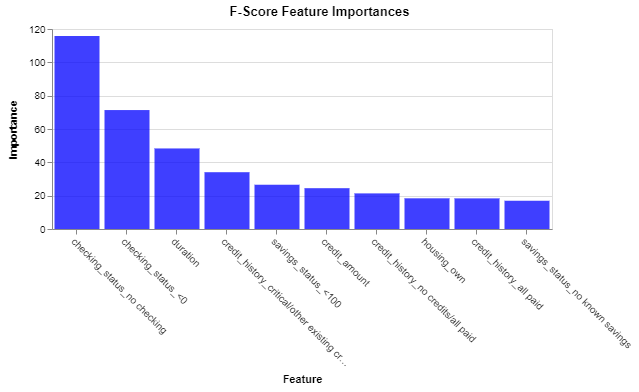

In [55]:
plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score', 'blue')

In [56]:
Data[:, fs_indices_fscore].shape

(1000, 10)

Let's now assess performance of this feature selection method using cross validation with the 1-nearest neighbour classifier.

In [57]:
cv_results_fscore = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_fscore],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_fscore.mean().round(3)

0.616

### Feature Selection Using Mutual Information

In this section we use mutual information to select the 10 most important features.

In [58]:
fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=num_features)
fs_fit_mutual_info.fit_transform(Data, target)
fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:num_features]
best_features_mutual_info = Data_df.columns[fs_indices_mutual_info].values
best_features_mutual_info

array(['checking_status_no checking', 'checking_status_<0',
       'num_dependents', 'job_skilled',
       'credit_history_critical/other existing credit',
       'property_magnitude_no known property', 'housing_for free',
       'purpose_new car', 'marital_status_single', 'purpose_other'],
      dtype=object)

In [59]:
feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
feature_importances_mutual_info

array([0.04518178, 0.03015153, 0.02969881, 0.02685252, 0.02669672,
       0.02480487, 0.02353616, 0.0202713 , 0.02025643, 0.02020802])

Visualising the importance: the most important feature is also `checking_status_no checking` which is significantly higher than the second most important feature. The features selected by mutual information are also different.

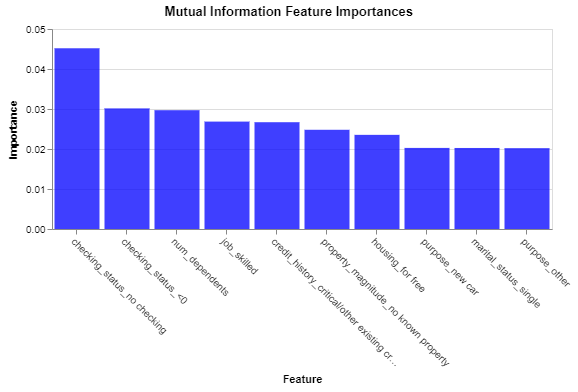

In [60]:
plot_imp(best_features_mutual_info, feature_importances_mutual_info, 'Mutual Information', 'blue')

Evaluating the performance of these features.

In [61]:
cv_results_mutual_info = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_mutual_info],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_mutual_info.mean().round(3)

0.567

## Feature Selection Performance Comparison Using Paired T-Tests

We then use repeated cross-validation for performance assessment. However, cross-validation is a random process and we need statistical tests in order to determine if any difference between the performance of any two feature selection methods is statistically significant; or if it is within the sample variation and the difference is statistically insignificant.

Since we fixed the random state to be the same for all cross-validation procedures, all feature selection methods were fitted and then tested on exactly the same data partitions. This indicates that our experiments were actually paired. Conducting experiments in a paired fashion reduces the variability significantly compared to conducting experiments in an independent fashion.

In this section, we conduct paired t-tests to see which differences between the full set of features and filter methods are statistically significant. 

The performance of different methods is summarised below:

In [62]:
print('Full Set of Features:', cv_results_full.mean().round(3))
print('F-Score:', cv_results_fscore.mean().round(3))
print('Mutual Information:', cv_results_mutual_info.mean().round(3))
print('RFI:', cv_results_rfi.mean().round(3))

Full Set of Features: 0.63
F-Score: 0.616
Mutual Information: 0.567
RFI: 0.578


Note that the performance of F-score is second to the performance of full set of features.

Now we compare conduct ttest between F-score and the other two methods. At a 95% significance level, if the p-value is smaller than 0.05, we conclude that the difference is statistically significant.

In [63]:
from scipy import stats
print(stats.ttest_rel(cv_results_fscore, cv_results_mutual_info).pvalue.round(3))
print(stats.ttest_rel(cv_results_fscore, cv_results_rfi).pvalue.round(3))

0.008
0.006


Based on the p-value, we conclude that F-score is statistically better than mutual information but not RFI. We also conduct a ttest between F-score and the full set of features. Here we observe a p-value of 0.26 which is above 0.05, indicating that the difference is not statically significant. Thus, F-score with 10 features performs not differently as the full set of features, at least for the 1-nearest neighbour classifier. We will use F-score in later hyperparameter tuning section.

In [64]:
stats.ttest_rel(cv_results_fscore, cv_results_full).pvalue.round(3)

0.26

### Data Train-Test Splitting

The original dataset has 1000 observations, so there is no need to take a smaller sample to shorten the run time. We will split the whole dataset into train and test partitions with a 70:30 ratio using stratification set to be `target`.

In [65]:
from sklearn.model_selection import train_test_split

Data_train, Data_test, target_train, target_test = train_test_split(Data, target, 
                                                                    test_size = 0.3, random_state=999,
                                                                    stratify = target)

print(Data_train.shape)
print(Data_test.shape)
print(target_train.shape)
print(target_test.shape)

(700, 60)
(300, 60)
(700,)
(300,)


# Predictive Modelling <a class="anchor" id="predictive_modelling"></a>
## Model Evaluation Strategy

We will train and tune our models on 700 rows of training data and test them on 300 rows of test data.

For each model, we will use 5-fold stratified cross-validation evaluation method with 3 repetitions for hyperparameter tuning.

In [66]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                     n_repeats=3,
                                     random_state=999)

## Hyperparameter Tuning

The five classifiers to be fitted in this section:
- K-Nearest Neighbours (KNN)
- Decision Trees (DT)
- (Gaussian) Naive Bayes (NB)
- Random forests ensemble method (RF)
- Support vector machines (SVM)

We will stack feature selection and grid search for hyperparameter tuning (via cross-validation) in a "pipeline". 
### K-Nearest Neighbours (KNN)

The `Pipeline` function is performed to:
1. Select feature using `SelectKBest` with `f_classif` as the score functions with 10, 20, and full set of features.
2. Train a KNN model with different number of nearest neighbours `k` and different distance measurements `p` values using AUC as our performance metrics.

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

pipe_KNN = Pipeline([('fselector', SelectKBest(score_func = f_classif)), 
                     ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'fselector__k': [10, 20, Data.shape[1]],
                   'knn__n_neighbors': [1, 3, 5, 10, 15, 20],
                   'knn__p': [1, 2]}
 
gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           n_jobs=-2,
                           scoring='roc_auc',
                           verbose=1) 

In [68]:
gs_pipe_KNN.fit(Data_train, target_train)

Fitting 15 folds for each of 36 candidates, totalling 540 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 540 out of 540 | elapsed:   37.2s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd2767bfba8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x7fd2767876a8>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [10, 20, 60], 'knn__n_neighbors': [1, 3, 5, 10, 15, 20], 'knn__p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [69]:
gs_pipe_KNN.best_params_

{'fselector__k': 60, 'knn__n_neighbors': 20, 'knn__p': 1}

In [70]:
gs_pipe_KNN.best_score_.round(3)

0.736

We observe that the optimal KNN model has a mean AUC score of 0.736. The best performing KNN selected the full set of features with 20 nearest neighbours and $p=1$ which is the Manhattan distance.

Even though these are the best values, let's have a look at the other combinations to see if the difference is rather significant or not. For this, we will make use of the function below to format the grid search outputs as a `Pandas` data frame.

In [71]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [72]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head(10)

mean_score  std_score  max_score  min_score  fselector__k  \
34    0.735941   0.067089   0.824830   0.563290          60.0   
22    0.732637   0.044955   0.836370   0.614189          20.0   
35    0.732305   0.067047   0.821672   0.554057          60.0   
23    0.731244   0.046643   0.837464   0.602770          20.0   
21    0.730345   0.044790   0.836127   0.618683          20.0   
20    0.729503   0.045140   0.836613   0.616254          20.0   
32    0.728231   0.059759   0.812804   0.577624          60.0   
10    0.724474   0.039717   0.808673   0.616011          10.0   
33    0.724328   0.065021   0.812075   0.556973          60.0   
18    0.724263   0.044237   0.810131   0.595360          20.0   

    knn__n_neighbors  knn__p  
34              20.0     1.0  
22              20.0     1.0  
35              20.0     2.0  
23              20.0     2.0  
21              15.0     2.0  
20              15.0     1.0  
32              15.0     1.0  
10              20.0     1.0  
33              15.0     2.0  
18              10.0     1.0

We observe that the difference between the hyperparameter combinations is not really much when conditioned on the number of features selected. Let's visualise the results of the grid search corresponding to 20 features since more than half of the top 10 KNN results have selected 20 features.

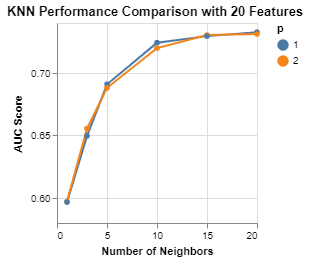

In [73]:
import altair as alt

results_KNN_20_features = results_KNN[results_KNN['fselector__k'] == 20.0]

alt.Chart(results_KNN_20_features, 
          title='KNN Performance Comparison with 20 Features'
         ).mark_line(point=True).encode(
    alt.X('knn__n_neighbors', title='Number of Neighbors'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('knn__p:N', title='p')
)

The visualisation of AUC score suggests our curve starts to flatten roughly when k is larger than 10.

### Decision Trees (DT)

We build a DT using the `Pipeline` function with the parameters below:
1. Perform feature selection using `SelectKBest` with `f_classif` as the score functions with 10, 20, and full set of features.
2. Train a DT model with different criterion, ,max depth and min samples split using AUC as our performance metric.

In [74]:
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('fselector', SelectKBest(score_func = f_classif)),
                    ('dt', DecisionTreeClassifier(random_state=999))])

params_pipe_DT = {'fselector__k': [10, 20, Data.shape[1]],
                  'dt__criterion': ['gini', 'entropy'],
                  'dt__max_depth': [3, 4, 5],
                  'dt__min_samples_split': [5, 50, 100, 150]}


gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT.fit(Data_train, target_train)

Fitting 15 folds for each of 72 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed:   20.7s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd2767bfba8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x7fd2767876a8>)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=999,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [10, 20, 60], 'dt__criterion': ['gini', 'entropy'], 'dt__max_depth': [3, 4, 5], 'dt__min_samples_split': [5, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [75]:
gs_pipe_DT.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 4,
 'dt__min_samples_split': 5,
 'fselector__k': 20}

In [76]:
gs_pipe_DT.best_score_.round(3)

0.717

We observe that the optimal KNN model has a mean AUC score of 0.717. The best performing DT selected 20 features with Gini index, max depth of 4 and min samples split of 5.

We will also have a look at the other combinations to see if the difference is rather significant or not. Likewise, the grid search is displayed below as a Pandas data frame.

In [77]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head(10)

mean_score  std_score max_score min_score dt__criterion dt__max_depth  \
13   0.716521  0.0449192  0.836735  0.618319          gini             4   
29   0.715752   0.036595  0.812196  0.628037          gini             5   
14   0.712812  0.0412394   0.81001  0.616132          gini             4   
27    0.71103  0.0333382  0.797376  0.639091          gini             5   
17   0.709167  0.0375077  0.790452  0.623299          gini             4   
31   0.709143  0.0368361   0.81171  0.665938          gini             5   
28   0.709014  0.0360834   0.81171  0.655491          gini             5   
32   0.708827  0.0408737  0.812196  0.640792          gini             5   
16   0.708576  0.0416783  0.821672  0.648081          gini             4   
25   0.708431  0.0375748  0.801749  0.644922          gini             5   

   dt__min_samples_split fselector__k  
13                     5           20  
29                    50           60  
14                     5           60  
27                    50           10  
17                    50           60  
31                   100           20  
28                    50           20  
32                   100           60  
16                    50           20  
25                     5           20

All the top results have selected gini as criterion. We also observe that the difference between the hyperparameter combinations is not really significantly different when conditioned on the number of features selected. Let's visualise the results of the grid search corresponding to 20 selected features with gini index.

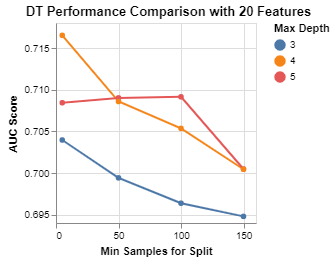

In [78]:
results_DT = get_search_results(gs_pipe_DT)

results_DT_20_features = results_DT[(results_DT['fselector__k'] == 20.0) & (results_DT['dt__criterion'] == 'gini')]

alt.Chart(results_DT_20_features, 
          title='DT Performance Comparison with 20 Features'
         ).mark_line(point=True).encode(
    alt.X('dt__min_samples_split', title='Min Samples for Split'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('dt__max_depth:N', title='Max Depth')
).interactive()

From the graph we can see that the AUC score decreases when `min_samples_split` increases. Among the 3 max depths, depth = 4 performs best until `min_samples_split` increases over 50 it is taken over by depth = 5. 

### (Gaussian) Naive Bayes (NB)

There is only one parameter to set for NB algorithm. We will optimise `var_smoothing` (a variant of Laplace smoothing) as we do not have any prior information about our dataset. We start with 10 and end with $10^{-3}$ with 200 different values (default value is $10^{-9}$) , but we perform a random search over only 20 different values (for shorter run times). 
<p>Since NB requires each descriptive feature to follow a Gaussian distribution, we first perform a power transformation on the input data before model fitting.

In [79]:
from sklearn.preprocessing import PowerTransformer
Data_train_transformed = PowerTransformer().fit_transform(Data_train)

In [80]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('fselector', SelectKBest(score_func = f_classif)), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'fselector__k': [10, 20, Data.shape[1]],
                  'nb__var_smoothing': np.logspace(1,-3, num=200)}

gs_pipe_NB = GridSearchCV(estimator=pipe_NB, 
                          param_grid=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 


gs_pipe_NB.fit(Data_train_transformed, target_train);

Fitting 15 folds for each of 600 candidates, totalling 9000 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 9000 out of 9000 | elapsed:  2.4min finished


In [81]:
gs_pipe_NB.best_params_

{'fselector__k': 60, 'nb__var_smoothing': 10.0}

In [82]:
gs_pipe_NB.best_score_.round(3)

0.773

The optimal NB yiels an AUC score of 0.773 (with full set of features).

In [83]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head(10)

mean_score  std_score  max_score  min_score  fselector__k  \
400    0.773453   0.044061   0.842566   0.649417          60.0   
401    0.773000   0.044046   0.841837   0.649174          60.0   
402    0.772595   0.043835   0.840379   0.649417          60.0   
403    0.772076   0.043876   0.840136   0.649174          60.0   
404    0.771672   0.043694   0.838435   0.649417          60.0   
405    0.771072   0.043830   0.837464   0.648202          60.0   
406    0.770586   0.043717   0.836249   0.648202          60.0   
407    0.770246   0.044156   0.835520   0.646016          60.0   
200    0.769631   0.035596   0.853499   0.678571          20.0   
202    0.769615   0.035361   0.853256   0.679786          20.0   

     nb__var_smoothing  
400          10.000000  
401           9.547716  
402           9.115888  
403           8.703591  
404           8.309942  
405           7.934097  
406           7.575250  
407           7.232634  
200          10.000000  
202           9.115888

Let's visualise the search results.
<p> Note that when the `var-smoothing`, i.e.: the portion of the largest variance of all features to be added to variances, increases, the AUC score also increases. 

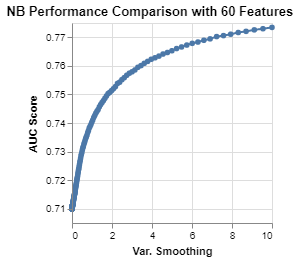

In [84]:
results_NB_60_features = results_NB[results_NB['fselector__k'] == 60.0]

alt.Chart(results_NB_60_features, 
          title='NB Performance Comparison with 60 Features'
         ).mark_line(point=True).encode(
    alt.X('nb__var_smoothing', title='Var. Smoothing'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False))
)

#### Random forests ensemble method (RF)
In the case of a random forest, we set the number of trees in the forest to be 100; the
hyperparameters are set as below:
1. `criterion` is the measure of impurity, here we set it to be "gini" and "entropy".
2. `max_depth` is the max number of levels in each decision tree, here we set it to be 3,4,5. 
3. `min_samples_split` is the minimum number of data points placed in a node before the node is split, here we set it to be 5, 50, 100, 150. 


In [85]:
from sklearn.ensemble import RandomForestClassifier

pipe_RF = Pipeline([('fselector', SelectKBest(score_func = f_classif)),
                    ('rf', RandomForestClassifier(n_estimators=100, random_state=999))])


params_pipe_RF = {'fselector__k': [10, 20, Data.shape[1]],
                  'rf__criterion': ['gini', 'entropy'],
                  'rf__max_depth': [3, 4, 5],
                  'rf__min_samples_split': [5, 50, 100, 150]}

gs_pipe_RF = GridSearchCV(estimator=pipe_RF, 
                          param_grid=params_pipe_RF, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_RF.fit(Data_train, target_train)

Fitting 15 folds for each of 72 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed:  5.0min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd2767bfba8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x7fd2767876a8>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_spl...tors=100, n_jobs=None,
            oob_score=False, random_state=999, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [10, 20, 60], 'rf__criterion': ['gini', 'entropy'], 'rf__max_depth': [3, 4, 5], 'rf__min_samples_split': [5, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [86]:
gs_pipe_RF.best_params_

{'fselector__k': 60,
 'rf__criterion': 'gini',
 'rf__max_depth': 5,
 'rf__min_samples_split': 5}

In [87]:
gs_pipe_RF.best_score_.round(3)

0.788

In [88]:
results_RF = get_search_results(gs_pipe_RF)
results_RF.head(10)

mean_score  std_score max_score min_score fselector__k rf__criterion  \
56    0.78816  0.0421074   0.88484  0.673712           60          gini   
68    0.78701  0.0393825  0.883382  0.676871           60       entropy   
64   0.785002  0.0428365   0.88654   0.67104           60       entropy   
69   0.784451  0.0414785  0.883868  0.670797           60       entropy   
57   0.783722  0.0402678  0.871477  0.670068           60          gini   
52    0.78335  0.0413851  0.871477  0.670797           60          gini   
48   0.783236  0.0446256  0.885083  0.661808           60          gini   
65   0.782847  0.0407602  0.877794  0.674198           60       entropy   
53   0.781438  0.0420167  0.869048  0.661565           60          gini   
60    0.78092  0.0445407  0.889942  0.662536           60       entropy   

   rf__max_depth rf__min_samples_split  
56             5                     5  
68             5                     5  
64             4                     5  
69             5                    50  
57             5                    50  
52             4                     5  
48             3                     5  
65             4                    50  
53             4                    50  
60             3                     5

The visualisation of above result shows that AUC scores decreases when the `min_samples_split` increases from 0 to 150. Note that the AUC scores tend to be stabilised when `min_samples_split`is greater than 100.

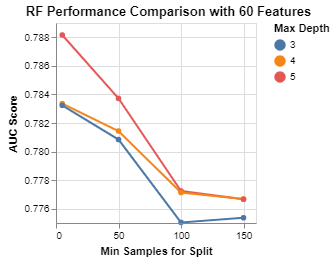

In [89]:
results_RF = get_search_results(gs_pipe_RF)

results_RF_60_features = results_RF[(results_RF['fselector__k'] == 60.0) & (results_RF['rf__criterion'] == 'gini')]

alt.Chart(results_RF_60_features, 
          title='RF Performance Comparison with 60 Features'
         ).mark_line(point=True).encode(
    alt.X('rf__min_samples_split', title='Min Samples for Split'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('rf__max_depth:N', title='Max Depth')
)

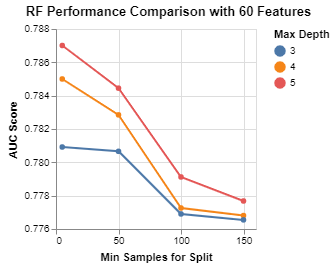

In [90]:
results_RF = get_search_results(gs_pipe_RF)

results_RF_60_features = results_RF[(results_RF['fselector__k'] == 60.0) & (results_RF['rf__criterion'] == 'entropy')]

alt.Chart(results_RF_60_features, 
          title='RF Performance Comparison with 60 Features'
         ).mark_line(point=True).encode(
    alt.X('rf__min_samples_split', title='Min Samples for Split'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('rf__max_depth:N', title='Max Depth')
)

#### Support vector machines (SVM)

We implement a `support vector machines (SVM)` model by: 

1. Perform feature selection using `SelectKBest` with `f_classif` as the score functions with 10, 20, and full set of features.

2. Train a SVM model with different `C`, `gamma` and `kernels` using AUC as our performance metric.


In [91]:
from sklearn.svm import SVC

pipe_SVM = Pipeline([('fselector', SelectKBest(score_func = f_classif)),
                    ('svc', SVC(random_state=999))])

params_pipe_SVM = {'fselector__k': [10, 20, Data.shape[1]],
                   'svc__C': [0.1,10,100], 
                   'svc__gamma': [0.1, 1, 10, 100],
                   'svc__kernel': ['linear', 'rbf']}



gs_pipe_SVM = GridSearchCV(estimator=pipe_SVM, 
                          param_grid=params_pipe_SVM, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_SVM.fit(Data_train, target_train)

Fitting 15 folds for each of 72 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed:  3.9min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd2767bfba8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x7fd2767876a8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=999,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [10, 20, 60], 'svc__C': [0.1, 10, 100], 'svc__gamma': [0.1, 1, 10, 100], 'svc__kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [92]:
gs_pipe_SVM.best_params_

{'fselector__k': 60, 'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}

In [93]:
gs_pipe_SVM.best_score_.round(3)

0.784

We observe that the `optimal SVM model` has a mean AUC score of 0.784. The best performing svm selected 60 features with C of 0.1, gamma of 0.1 and linear kernel.

We will also have a look at the other combinations to see if the difference is rather significant or not. For this, we will make use of the function below to format the grid search outputs as a Pandas data frame.

In [94]:
results_SVM = get_search_results(gs_pipe_SVM)
results_SVM.head(10)

mean_score  std_score max_score min_score fselector__k svc__C svc__gamma  \
48   0.784095  0.0437164  0.872206  0.690233           60    0.1        0.1   
54   0.784095  0.0437164  0.872206  0.690233           60    0.1        100   
50   0.784095  0.0437164  0.872206  0.690233           60    0.1          1   
52   0.784095  0.0437164  0.872206  0.690233           60    0.1         10   
49   0.779187  0.0488896  0.872692  0.662293           60    0.1        0.1   
62   0.772352  0.0394045  0.851555  0.692906           60     10        100   
60   0.772352  0.0394045  0.851555  0.692906           60     10         10   
58   0.772352  0.0394045  0.851555  0.692906           60     10          1   
56   0.772352  0.0394045  0.851555  0.692906           60     10        0.1   
70   0.771396  0.0393675  0.847425  0.686589           60    100        100   

   svc__kernel  
48      linear  
54      linear  
50      linear  
52      linear  
49         rbf  
62      linear  
60      linear  
58      linear  
56      linear  
70      linear

We observe that the difference between the hyperparameter combinations is not really significantly different when conditioned on the number of features selected. Let's visualise the results of the grid search corresponding to 60 selected features with linear kernel.

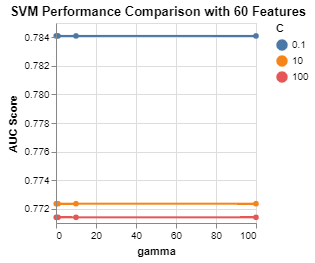

In [95]:
results_SVM = get_search_results(gs_pipe_SVM)

results_SVM_60_features = results_SVM[(results_SVM['fselector__k'] == 60.0) & (results_SVM['svc__kernel'] == 'linear')]

alt.Chart(results_SVM_60_features, 
          title='SVM Performance Comparison with 60 Features'
         ).mark_line(point=True).encode(
    alt.X('svc__gamma', title='gamma'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('svc__C:N', title='C')
)

From the diagram above, looks like AUC is highest when C is 0.1 with linear kernel. The AUC scores seem to be not significantly different than each other in each C value. 

## Further Fine Tuning

We notice that the performance of the SVM method relies more on the C value rather than gamma value in our case. On top of that, when C equals 0.1 performs much better than C values at 10 or 100. Thus, we need to go beyond what we already tried to make sure that we are not missing out on even better values. For this reason, we try a new search as below by lowering C value.

In [96]:
from sklearn.svm import SVC

pipe_SVM = Pipeline([('fselector', SelectKBest(score_func = f_classif)),
                    ('svc', SVC(random_state=999))])

params_pipe_SVM = {'fselector__k': [10, 20, Data.shape[1]],
                   'svc__C': [0.001, 0.01, 0.1,1], 
                   'svc__gamma': [0.1, 1, 10, 100],
                   'svc__kernel': ['linear', 'rbf']}



gs_pipe_SVM_2 = GridSearchCV(estimator=pipe_SVM, 
                          param_grid=params_pipe_SVM, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_SVM_2.fit(Data_train, target_train)

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 1440 out of 1440 | elapsed:  1.8min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd2767bfba8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x7fd2767876a8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=999,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [10, 20, 60], 'svc__C': [0.001, 0.01, 0.1, 1], 'svc__gamma': [0.1, 1, 10, 100], 'svc__kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [97]:
gs_pipe_SVM_2.best_params_

{'fselector__k': 60, 'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}

In [98]:
gs_pipe_SVM_2.best_score_.round(3)

0.784

In [99]:
results_SVM_2 = get_search_results(gs_pipe_SVM_2)
results_SVM_2.head(10)

mean_score  std_score max_score min_score fselector__k svc__C svc__gamma  \
82   0.784095  0.0437164  0.872206  0.690233           60    0.1          1   
84   0.784095  0.0437164  0.872206  0.690233           60    0.1         10   
80   0.784095  0.0437164  0.872206  0.690233           60    0.1        0.1   
86   0.784095  0.0437164  0.872206  0.690233           60    0.1        100   
89   0.783333  0.0484101  0.876579  0.666181           60      1        0.1   
72   0.779446  0.0446374  0.864674   0.67517           60   0.01        0.1   
74   0.779446  0.0446374  0.864674   0.67517           60   0.01          1   
78   0.779446  0.0446374  0.864674   0.67517           60   0.01        100   
76   0.779446  0.0446374  0.864674   0.67517           60   0.01         10   
66   0.779284  0.0439519  0.864674  0.679057           60  0.001          1   

   svc__kernel  
82      linear  
84      linear  
80      linear  
86      linear  
89         rbf  
72      linear  
74      linear  
78      linear  
76      linear  
66      linear

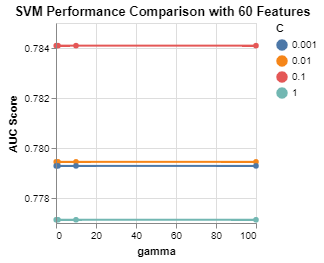

In [100]:
results_SVM_2 = get_search_results(gs_pipe_SVM_2)

results_SVM_60_features_2 = results_SVM_2[(results_SVM_2['fselector__k'] == 60.0) & (results_SVM_2['svc__kernel'] == 'linear')]

alt.Chart(results_SVM_60_features_2, 
          title='SVM Performance Comparison with 60 Features'
         ).mark_line(point=True).encode(
    alt.X('svc__gamma', title='gamma'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('svc__C:N', title='C')
)

Regardless of reducing the C value from the diagram above, the AUC score is still highest when C is 0.1 with linear kernel. Therefore, we will stick with the output before further fine tuning.

# Performance Comparison <a class="anchor" id="performance_comparison"></a> 

During the hyperparameter tuning phase above, we used the 700 rows in our training data within a cross-validation framework and we determined the best hyperparameter values for each of the five classifiers. For instance, for KNN, it turned out that the best set of hyperparameter values is $k=20$ and $p=1$ with the full set of features as selected by the F-score feature selection method.

What we will do now is to fit each tuned classifier (with the best set of hyperparameter values) on the 300 rows in the test data in a cross-validated fashion to figure out which (tuned) classifier performs the best. This way, we would be measuring performance of the tuned classifiers on data that they did not see previously. 

Since cross validation itself is a random process, we would like to perform pairwise t-tests to determine if any difference between the performance of any two (tuned) classifiers is statistically significant. Specifically, we first perform 10-fold stratified cross-validation (without any repetitions) on each (tuned) classifier where we use the same seed in each of the three cross-validation runs. Second, we conduct a paired t-test for the AUC score between the following (tuned) classifier combinations:

* KNN vs. DT,
* KNN vs. NB,
* KNN vs. RF,
* KNN vs. SVM,
* DT vs. NB,
* DT vs. RF,
* DT vs. SVM,
* NB vs. RF,
* NB vs. SVM, and
* RF vs. SVM.

In [101]:
{'fselector__k': 60, 'knn__n_neighbors': 20, 'knn__p': 1}

{'fselector__k': 60, 'knn__n_neighbors': 20, 'knn__p': 1}

In [102]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=999)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=Data_test,
                                 y=target_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.6563492063492063

In [103]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT.best_estimator_,
                                 X=Data_test,
                                 y=target_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_DT.mean()

0.6444444444444444

In [104]:
cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                 X=Data_test,
                                 y=target_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_NB.mean()

0.7365079365079364

In [105]:
cv_results_RF = cross_val_score(estimator=gs_pipe_RF.best_estimator_,
                                 X=Data_test,
                                 y=target_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_RF.mean()

0.725925925925926

In [106]:
cv_results_SVM = cross_val_score(estimator=gs_pipe_SVM.best_estimator_,
                                 X=Data_test,
                                 y=target_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_SVM.mean()

0.7132275132275132

Since we fixed the random state to be same during cross-validation, all (tuned) classifiers were fitted and then tested on exactly the same data partitions, making our results "paired" in a statistical sense. So, we use the `stats.ttest_rel` function from the `SciPy` module to run the following (paired) t-tests.

In [107]:
from scipy import stats

print('KNN & DT:', stats.ttest_rel(cv_results_KNN, cv_results_DT))
print('KNN & NB:', stats.ttest_rel(cv_results_KNN, cv_results_NB))
print('KNN & RF:', stats.ttest_rel(cv_results_KNN, cv_results_RF))
print('KNN & SVM:', stats.ttest_rel(cv_results_KNN, cv_results_SVM))
print('DT & NB:', stats.ttest_rel(cv_results_DT, cv_results_NB))
print('DT & RF:', stats.ttest_rel(cv_results_DT, cv_results_RF))
print('DT & SVM:', stats.ttest_rel(cv_results_DT, cv_results_SVM))
print('NB & RF:', stats.ttest_rel(cv_results_NB, cv_results_RF))
print('NB & SVM:', stats.ttest_rel(cv_results_NB, cv_results_SVM))
print('RF & SVM:', stats.ttest_rel(cv_results_RF, cv_results_SVM))

KNN & DT: Ttest_relResult(statistic=0.353984601567733, pvalue=0.7315018123574506)
KNN & NB: Ttest_relResult(statistic=-3.846002216806674, pvalue=0.003930270306101203)
KNN & RF: Ttest_relResult(statistic=-3.5841057685062623, pvalue=0.005892809412132159)
KNN & SVM: Ttest_relResult(statistic=-3.069167546097163, pvalue=0.013371973806067717)
DT & NB: Ttest_relResult(statistic=-3.0574451378343546, pvalue=0.013627806049657267)
DT & RF: Ttest_relResult(statistic=-2.696319459689428, pvalue=0.024541180700269255)
DT & SVM: Ttest_relResult(statistic=-2.5373401896661885, pvalue=0.031849472500615914)
NB & RF: Ttest_relResult(statistic=0.7947194142390267, pvalue=0.44722613195784977)
NB & SVM: Ttest_relResult(statistic=1.5955812741980877, pvalue=0.14504669499871053)
RF & SVM: Ttest_relResult(statistic=0.8652746230591895, pvalue=0.4093594280609767)


A p-value smaller than 0.05 indicates a statistically significant difference. Looking at these results, we conclude that at a 95% significance level, DT is statistically the best model in this output (in terms of AUC) when compared on the test data.

Though we used AUC to optimise the algorithm hyperparameters, we shall consider the following metrics to evaluate models based on the test set:

* Accuracy
* Precision
* Recall
* F1 Score (the harmonic average of precision and recall)
* Confusion Matrix

These metrics can be computed using `classification_report` from `sklearn.metrics`. The classification reports are shown below.

In [108]:
pred_KNN = gs_pipe_KNN.predict(Data_test)

In [109]:
pred_DT = gs_pipe_DT.predict(Data_test)

In [110]:
Data_test_transformed = PowerTransformer().fit_transform(Data_test)
pred_NB = gs_pipe_NB.predict(Data_test_transformed)

In [111]:
pred_RF = gs_pipe_RF.predict(Data_test)

In [112]:
pred_SVM = gs_pipe_SVM.predict(Data_test)

In [113]:
from sklearn import metrics
print("\nClassification report for K-Nearest Neighbour") 
print(metrics.classification_report(target_test, pred_KNN))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(target_test, pred_DT))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(target_test, pred_NB))
print("\nClassification report for Random Forest") 
print(metrics.classification_report(target_test, pred_RF))
print("\nClassification report for Support Vector Machine") 
print(metrics.classification_report(target_test, pred_SVM))


Classification report for K-Nearest Neighbour
              precision    recall  f1-score   support

           0       0.73      0.95      0.82       210
           1       0.58      0.17      0.26        90

   micro avg       0.71      0.71      0.71       300
   macro avg       0.65      0.56      0.54       300
weighted avg       0.68      0.71      0.65       300


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       210
           1       0.48      0.30      0.37        90

   micro avg       0.69      0.69      0.69       300
   macro avg       0.61      0.58      0.58       300
weighted avg       0.66      0.69      0.67       300


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       210
           1       0.00      0.00      0.00        90

   micro avg       0.70      0.70      0.70       300
 

** Confusion Matrix**

In [114]:
from sklearn import metrics
print("\nConfusion matrix for K-Nearest Neighbour") 
print(metrics.confusion_matrix(target_test, pred_KNN))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(target_test, pred_DT))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(target_test, pred_NB))
print("\nConfusion matrix for Random Forest") 
print(metrics.confusion_matrix(target_test, pred_RF))
print("\nConfusion matrix for Support Vector Machine") 
print(metrics.confusion_matrix(target_test, pred_SVM))


Confusion matrix for K-Nearest Neighbour
[[199  11]
 [ 75  15]]

Confusion matrix for Decision Tree
[[181  29]
 [ 63  27]]

Confusion matrix for Naive Bayes
[[210   0]
 [ 90   0]]

Confusion matrix for Random Forest
[[203   7]
 [ 74  16]]

Confusion matrix for Support Vector Machine
[[186  24]
 [ 55  35]]


Suppose we are a bank and we would like to detect individuals with class as 'bad', potential to default. In this case, we would choose recall as the performance metrix. In this context, SVM would be the best performer since it produces the highest recall score for the 'bad' class. Our result from the confusion matrix of SVM is in line with this.

# Limitations and Proposed Solutions <a class="anchor" id="limitations"></a> 

- **Sample size** <br> This data is relatively small to train our models. It has only 1000 observations with limited 300 `bad` class observations. Since bad class is what we are interested in, we need more data to improve the performance of the models. A data set with more than 5000 observations will be ideal.


- **Feature selection and feature ranking**
<br> In this report, full set of features is preferred in most of the models. The reason might be the small sample limits the performance of hyperparameter tuning. With larger dataset, this may be mitigated. In other words, we might be able to select 10 to 15 features to avoid overfitting, which increases the performance of the models. 


- **Fine tune** <br> For Support vector machines (SVM) model, we notice the performance of the model relies more on the C value rather than gamma value in our case.  On top of that, when C equals 0.1 performs much better than C values at 10 or 100. So we further fine tune the model by lowering C values from 0.1 to 0.001. Although the result shows AUC scores is still the highest for C value of 0.1, they seem to be not significantly different than each other in each C value. Accordingly, we can try to further specify more smaller C values to ensure that we are not missing out on even better values., e.g. 0.00001.
 


# Summary and Conclusion   <a class="anchor" id="conclusion"></a>

When evaluated on the train data (in a cross-validated fashion), the Random Forest model outperforms the other four models with respect to AUC. Whereas, Naive Bayes model with the full set of features selected by F-score, with var smoothing equals to 10  produces the highest cross-validated AUC score on the testing data.  However, the Naive Bayes model falsely classified all the negative value (bad customers as good) in the test set. We should prefer the Random Forest method by looking at the result of AUC score when fit it in the test data. The Support Vector Machine model yields the highest recall score on the test data. We also observe that our models are not very sensitive to the number of features as selected by F-score when conditioned on the values of the hyperparameters in general. For this reason, it seems working with 20 features is preferable to working with the full feature set, which potentially avoids overfitting and results in models that are easier to train and easier to understand.

# Reference   <a class="anchor" id="reference"></a>

* Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [online]. Irvine, CA: University of California, School of Information and Computer Science. Available at https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) 
* Data was accessed and downloaded from https://www.openml.org/d/31 [Accessed 2020-05-25]


